# Project MMCN

## Initialisation

Le projet utilise NumPy, Matplotlib, SciPy et SymPy, et a été testé sur Python 3.11.

In [1]:
# Imports

from typing import Literal, Optional

import numpy as np
import sympy
from matplotlib import pyplot as plt
from matplotlib import transforms
from matplotlib.axes import Axes
from matplotlib.patches import Circle
from matplotlib.patheffects import withStroke
from matplotlib.rcsetup import cycler
from scipy import integrate
from scipy.interpolate import interp1d
from sympy import Eq, Matrix, Symbol
from sympy.abc import x, y


In [2]:
# Réglages Matplotlib

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.figsize'] = 21.0 / 2.54 - 2.0, 4.0
plt.rcParams['font.size'] = 11.0
plt.rcParams['figure.dpi'] = 288
plt.rcParams['grid.color'] = 'whitesmoke'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['axes.prop_cycle'] = cycler(color=[
  '#348abd',
  '#e24a33',
  '#988ed5',
  '#fbc15e',
  '#777777',
  '#8eba42',
  '#ffb5b8'
])
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor'] = 'k'


In [3]:
# Fonctions utilitaires

# Retourne vrai si x est un nombre réel avec une tolérance.
isclosereal = lambda x: np.isclose(x.imag, 0)

# Affiche une expression sympy
format_ex = lambda value: str(value).replace('x', 'v_0').replace('**', '^').replace('*', '')

# Affiche des solutions sympy
format_sols = lambda sols: format_ex(' ou '.join([f'x = {sol}' for sol in sols]))

def group(x: np.ndarray, /):
  """
  Group adjacent elements in the first axis of the input ndarray.
  """

  current_item = x[0, ...]
  current_count = 1

  for index in range(1, x.shape[0]):
    if x[index, ...] != current_item:
      yield current_item, current_count
      current_item = x[index, ...]
      current_count = 1
    else:
      current_count += 1

  yield current_item, current_count


def draw_circle(ax: Axes, point: np.ndarray | list[float], *, color: str = 'black', label: Optional[str] = None, position: Literal['bottom', 'left', 'right'] = 'right'):
  """
  Draw a circle on a matplotlib Axes, optionally with a label.
  """

  trans = ax.get_figure().dpi_scale_trans + transforms.ScaledTranslation(point[0], point[1], ax.transData)
  circle = Circle((0.0, 0.0), clip_on=False, edgecolor=color, linewidth=1, facecolor='none', path_effects=[withStroke(linewidth=3, foreground='white')], radius=0.05, transform=trans, zorder=10)

  ax.add_artist(circle)

  if label is not None:
    ax.text(
      *({
        'bottom': (0.0, -0.08),
        'left': (-0.1, -0.005),
        'right': (0.1, -0.005)
      }[position]),
      label,
      ha={
        'bottom': 'center',
        'left': 'right',
        'right': 'left'
      }[position],
      va={
        'bottom': 'top',
        'left': 'center',
        'right': 'center'
      }[position],
      color=color,
      fontsize=8,
      path_effects=[withStroke(linewidth=2, foreground='white')],
      transform=trans
    )


## Questions 1 et 2

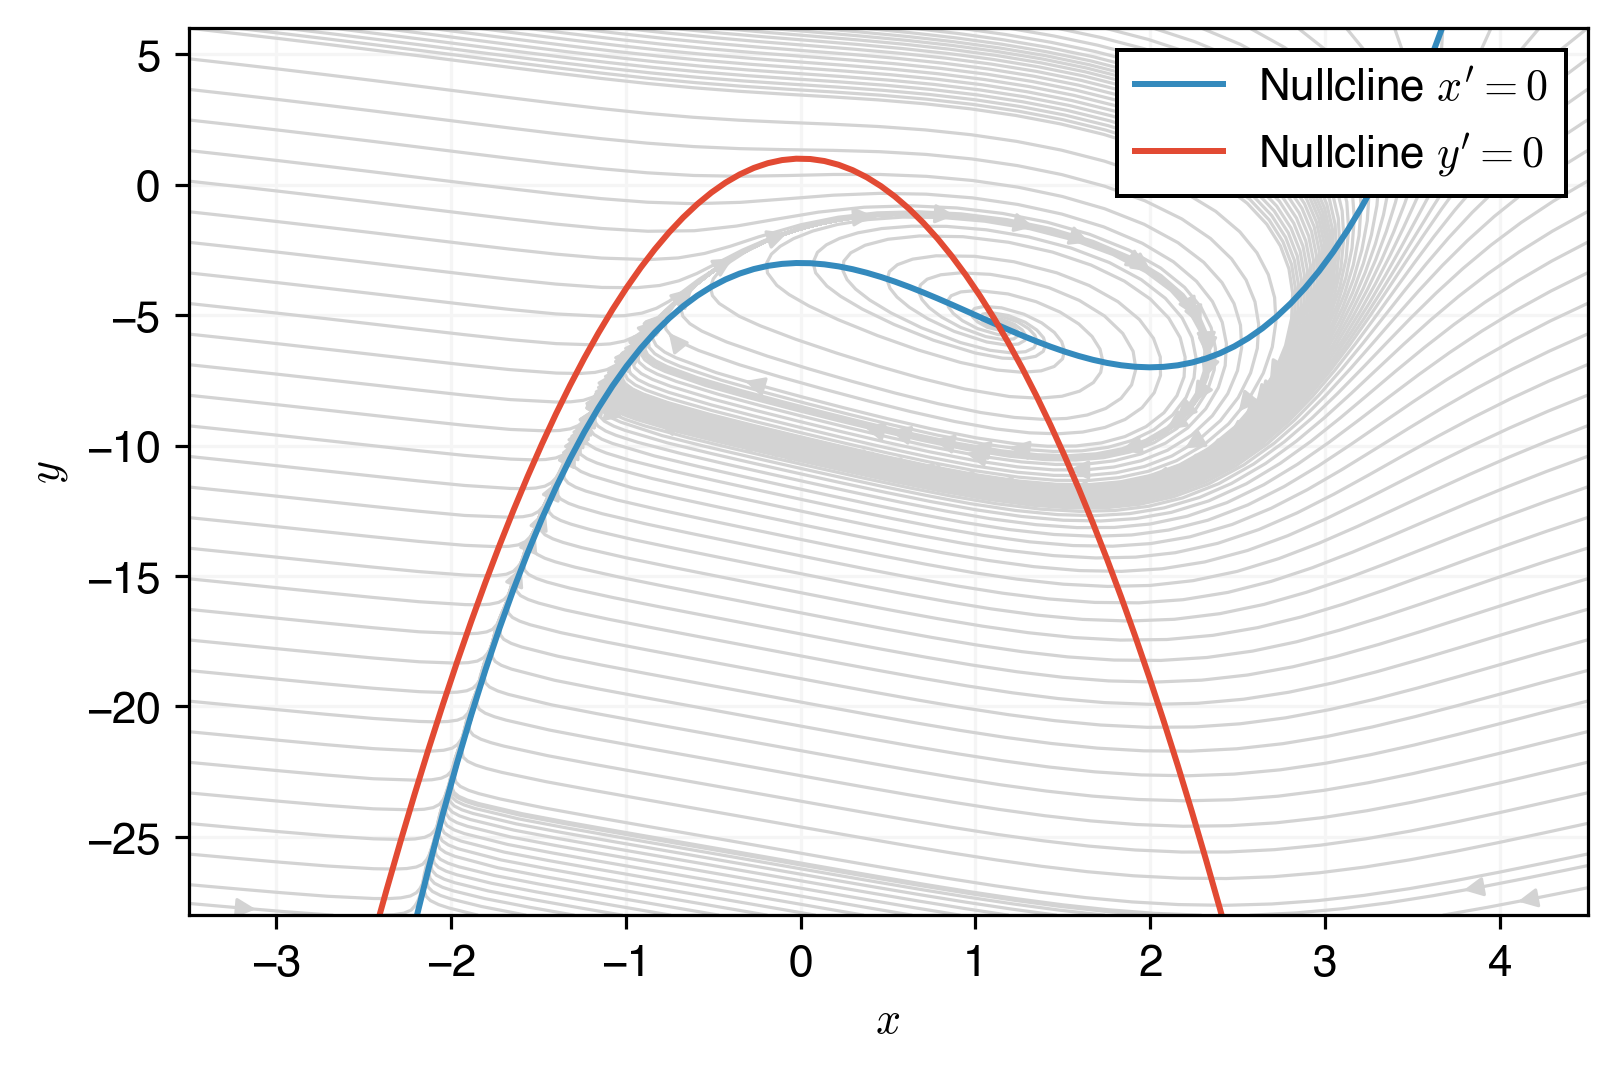

In [4]:
def plot_example():
  # Système d'équations différentielles sous forme numérique
  def system(y: np.ndarray, *, c: float, z: float):
    return np.array([
      (y[1, ...] - y[0, ...]**3 + 3.0 * y[0, ...]**2 + z) / c,
      1.0 - 5.0 * y[0, ...]**2 - y[1, ...]
    ])

  # Solution des nullclines sous forme numérique
  def nullclines(x: np.ndarray, *, z: float):
    return np.array([
      (x**3 - 3.0 * x**2) - z,
      (1.0 - 5.0 * x**2)
    ])

  c = 1.0
  z = 3.0

  fig, ax = plt.subplots()

  ylim = -28, 6
  x = np.linspace(-3.5, 4.5, 100)
  y = np.linspace(*ylim, 100)

  # Calcul des nullclines
  ncl = nullclines(x, z=z)

  # Évaluation du système pour le tracé des trajectoires
  X, Y = np.meshgrid(x, y)
  UV = system(np.array([X, Y]), c=c, z=z)

  # Tracé des trajectoires
  ax.streamplot(X, Y, UV[0, :], UV[1, :], color='lightgray', density=1.0, linewidth=0.8, broken_streamlines=False)

  # Tracé des nullclines
  ax.plot(x, ncl[0, :], label='Nullcline $x\' = 0$')
  ax.plot(x, ncl[1, :], label='Nullcline $y\' = 0$')

  ax.legend()
  ax.set_ylim(*ylim)
  ax.grid()

  ax.set_xlabel('$x$')
  ax.set_ylabel('$y$')

plot_example()


In [5]:
z = Symbol('z', real=True)

# Objet qui contient le modèle pour une valeur donnée de c
class Model:
  def __init__(self, *, c: int):
    self.c = c

    # Définition du système d'équations avec SymPy
    self.system = Matrix([
      (y - x**3 + 3 * x**2 + z) / c,
      1 - 5*x**2 - y
    ])

    # Calcul de la matrice jacobienne par rapport à x et y
    self.jacobian: Matrix = self.system.jacobian(Matrix([x, y]))

    # Résolution analytique des points stationnaires en transformant la seconde équation en y = f(x)
    # puis en l'insérant dans la première, ce qui donne un polynôme du troisième degré. Cela donne trois solutions parfois complexes.
    self.y_eq = sympy.solve(Eq(self.system[1], 0), y)[0]
    eq0_sols = self.system[0].subs(y, self.y_eq) # type: ignore
    self.x_sols = sympy.solve(Eq(eq0_sols, 0), x)

    # Résolution des valeurs propres de la matrice jacobienne
    self.eigenval1, self.eigenval2 = iter(self.jacobian.eigenvals().keys())

    # Condition pour des valeurs propres complexes conjuguées
    self.complex_eigenval_boundary_eq = self.jacobian.trace() ** 2 - 4 * self.jacobian.det()

  # Retourne les points stationnaires pour des valeurs données de z
  def get_stat_points(self, zr: np.ndarray):
    # On substitue les valeurs numériques de z dans la solution analytique
    xs_unflattened = np.asarray(sympy.lambdify(z, self.x_sols, 'numpy')(zr.astype(complex)))
    xs = xs_unflattened.ravel()
    zs = np.tile(zr, xs_unflattened.shape[0])

    # Filtrage des solutions complexes
    mask = isclosereal(xs)

    # On trie les points stationnaires par ordre croissant de x pour un meilleur affichage
    order = np.argsort(xs[mask])

    xs = xs[mask][order].real
    zs = zs[mask][order].real

    # Calcul de y
    ys = np.asarray(sympy.lambdify(x, self.y_eq, 'numpy')(xs))

    return np.array([xs, ys, zs]).T

  # Étant donné un ndarray de points stationnaires, retourne la trace de la matrice jacobienne pour chaque point
  def get_trace(self, sp: np.ndarray):
    return np.asarray(sympy.lambdify(x, self.jacobian.trace(), 'numpy')(sp[:, 0]))

  # Étant donné un ndarray de points stationnaires, retourne le déterminant de la matrice jacobienne pour chaque point
  def get_det(self, sp: np.ndarray):
    return np.asarray(sympy.lambdify(x, self.jacobian.det(), 'numpy')(sp[:, 0]))

  # Étant donné un ndarray de points stationnaires, retourne la stabilité de chaque point
  def is_stable(self, sp: np.ndarray):
    return (self.get_trace(sp).real < 0.0) & (self.get_det(sp).real > 0.0)

  # Étant donné un ndarray de points stationnaires, retourne les valeurs propres de la matrice jacobienne pour chaque point
  def get_eigenvalues(self, sp: np.ndarray):
    return np.asarray(sympy.lambdify(x, list(self.jacobian.eigenvals().keys()), 'numpy')(sp[:, 0].astype(complex))).T

  # Affiche les réponses aux questions
  def summary(self):
    # Complex conjugate eigenvalues

    print('Condition for complex conjugate eigenvalues:')
    print(format_ex(sympy.expand(self.complex_eigenval_boundary_eq)) + ' = 0')
    print([f'{sol.evalf():.3f}' for sol in sympy.solve(Eq(self.complex_eigenval_boundary_eq, 0), x) if sol.is_real])
    print()

    # Saddle-node bifurcations

    bif1_x = sympy.solve(Eq(self.jacobian.det(), 0), x)

    print('Condition for saddle-node bifurcation:')
    print(format_ex(self.jacobian.det()) + ' = 0')
    print(format_sols(bif1_x))
    print()


    # Hopf bifurcations

    bif2_x = sympy.solve(Eq(self.jacobian.trace(), 0))

    print('Condition for Hopf bifurcation:')
    print(format_ex(self.jacobian.trace()) + ' = 0')
    print(format_sols(bif2_x))


    self.bifurcations_x = np.array([float(x.evalf()) for x in [*bif1_x, *bif2_x]])

model1 = Model(c=1)
model2 = Model(c=2)

print('Model 1\n')
model1.summary()

print('\n\nModel 2\n')
model2.summary()


Model 1

Condition for complex conjugate eigenvalues:
9v_0^4 - 36v_0^3 + 30v_0^2 - 28v_0 + 1 = 0
['3.268', '0.037']

Condition for saddle-node bifurcation:
3v_0^2 + 4v_0 = 0
v_0 = -4/3 ou v_0 = 0

Condition for Hopf bifurcation:
-3v_0^2 + 6v_0 - 1 = 0
v_0 = 1 - sqrt(6)/3 ou v_0 = sqrt(6)/3 + 1


Model 2

Condition for complex conjugate eigenvalues:
9v_0^4/4 - 9v_0^3 + 6v_0^2 - 14v_0 + 1 = 0
['3.724', '0.073']

Condition for saddle-node bifurcation:
3v_0^2/2 + 2v_0 = 0
v_0 = -4/3 ou v_0 = 0

Condition for Hopf bifurcation:
-3v_0^2/2 + 3v_0 - 1 = 0
v_0 = 1 - sqrt(3)/3 ou v_0 = sqrt(3)/3 + 1


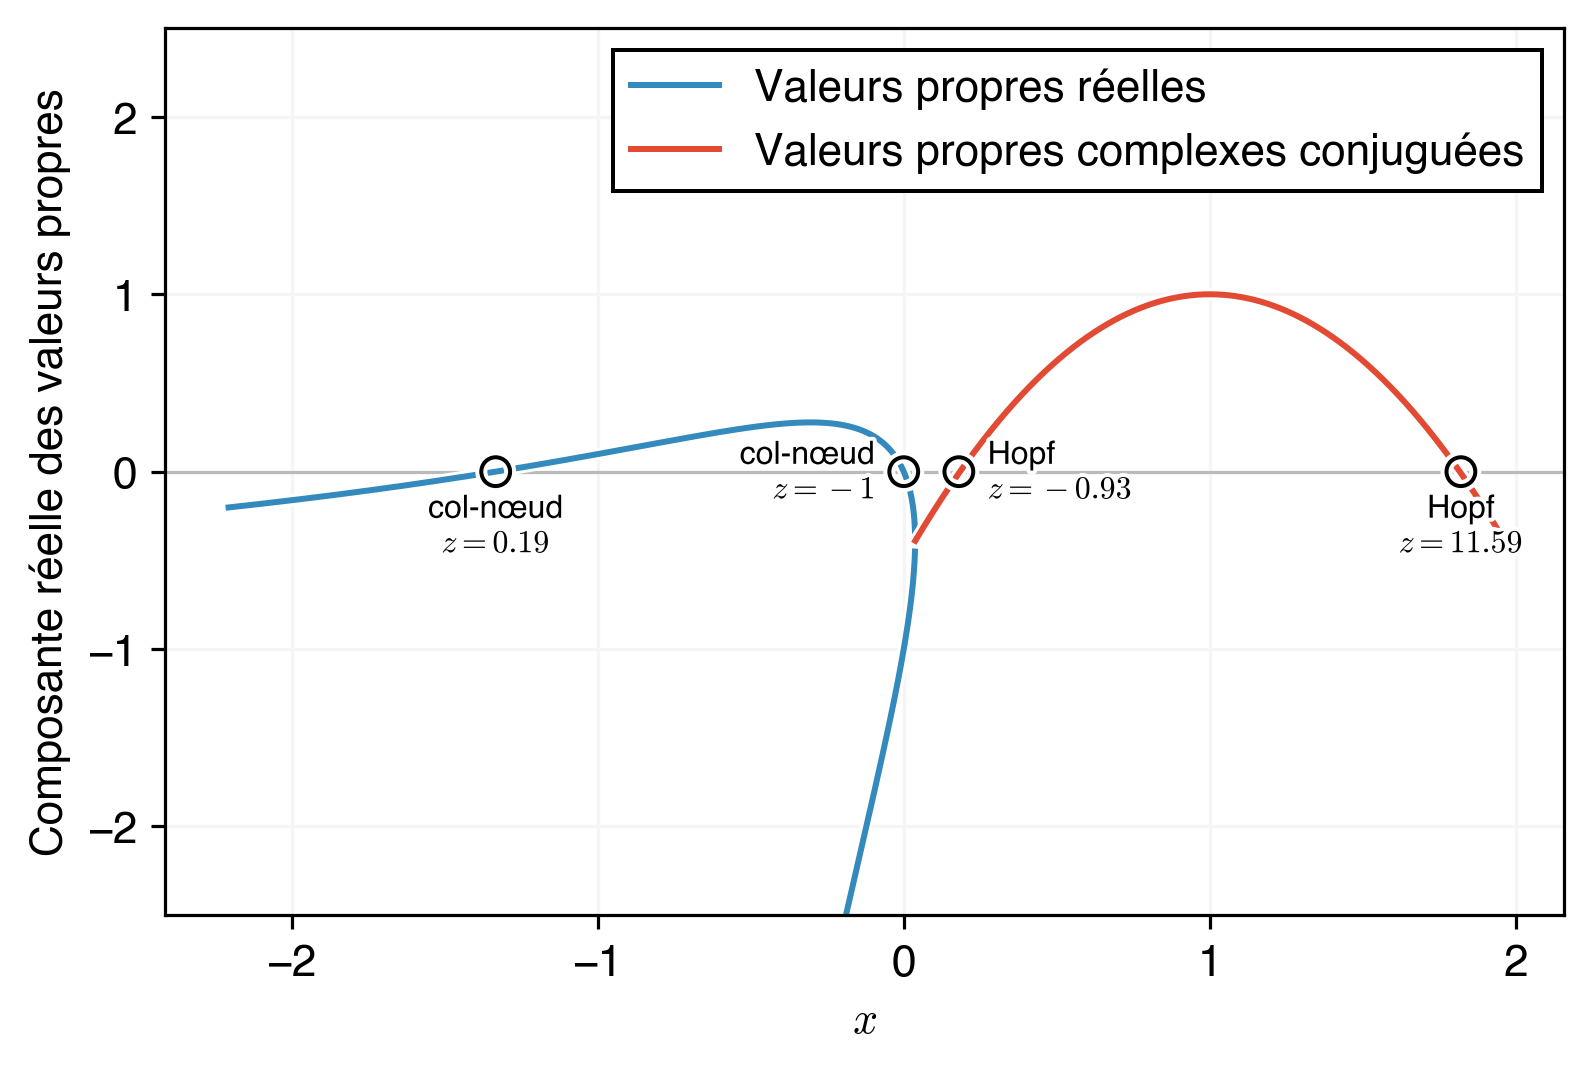

In [6]:
def plot_eigenvalues(model: Model):
  # Calcul des points stationnaires et de leur valeurs propres
  stat_points = model.get_stat_points(np.linspace(-2, 14, 100000))
  eig = model.get_eigenvalues(stat_points)


  fig, ax = plt.subplots()

  ax.set_ylim(-2.5, 2.5)
  ax.axhline(0, alpha=0.5, color='gray', linewidth=0.8)

  # Création d'un masque pour savoir si les valeurs propres sont réelles
  eig_real = isclosereal(eig[:, 0])

  # Affichage des différentes courbes
  ax.plot(stat_points[eig_real, 0], eig[eig_real, 0].real, color='C0', label='Valeurs propres réelles', path_effects=[withStroke(linewidth=3, foreground='white')])
  ax.plot(stat_points[eig_real, 0], eig[eig_real, 1].real, color='C0', path_effects=[withStroke(linewidth=3, foreground='white')])
  ax.plot(stat_points[~eig_real, 0], eig[~eig_real, 0].real, color='C1', label='Valeurs propres complexes conjuguées', path_effects=[withStroke(linewidth=3, foreground='white')])
  ax.grid()

  # Affichage des points stationnaires à partir de valeurs approchées des points trouvés plus haut
  draw_circle(ax, [-1.333, 0], label='col-nœud\n$z = 0.19$', position='bottom')
  draw_circle(ax, [0.18, 0], label='Hopf\n$z = -0.93$', position='right')
  draw_circle(ax, [0, 0], label='col-nœud\n$z = -1$', position='left')
  draw_circle(ax, [1.82, 0], label='Hopf\n$z = 11.59$', position='bottom')

  ax.set_xlabel('$x$')
  ax.set_ylabel('Composante réelle des valeurs propres')

  ax.legend()

plot_eigenvalues(model1)


In [7]:
# Simulation d'une trajectoire partant d'un point donné
def run_z(xp: float, yp: float, zp: float, *, c: int):
  integr = integrate.solve_ivp(lambda t, y: [
    (y[1, ...] - y[0, ...]**3 + 3.0 * y[0, ...]**2 + zp) / c,
    1.0 - 5.0 * y[0, ...]**2 - y[1, ...]
  ],
    method='RK23',
    # Variation des limites de temps pour éviter trop de calcul
    t_span=(0, 1000 if zp < (11 if c == 1 else 7) else 10000),
    # Ajout d'une petite perturbation pour éviter de rester dans un point stationnaire
    y0=[xp + 1e-14, yp],
    max_step=0.1,
    vectorized=True
  )

  # On retourne les valeurs minimales et maximales de x pour trouver les limites du cycle
  return [
    np.min(integr.y[0, :]),
    np.max(integr.y[0, :])
  ]


# Calcul des min et max du cycle limite
# Ceci peut prendre une minute
def get_limit_cycle(model: Model):
  # Calcul des points stationnaires
  stat_points_all = model.get_stat_points(np.linspace(-2, 14, 100))

  # Filtrage des points stationnaires qui correspondent au cycle limite
  mask = (stat_points_all[:, 0] > 0) & ~model.is_stable(stat_points_all)
  stat_points = stat_points_all[mask, :]

  limit_cycle = np.array([run_z(*stat_points[index, :], c=model.c) for index in range(stat_points.shape[0])])

  # Second filtrage pour s'arrêter à la bifurcation homocline
  if model.c == 1:
    i = limit_cycle.shape[0] - np.argmax(limit_cycle[::-1, 0] < -1.5) - 1 + 1

    limit_cycle = limit_cycle[i:, :]
    stat_points = stat_points[i:, :]

  return limit_cycle, stat_points


def summarize_model1_limit_cycle():
  limit_cycle, stat_points = get_limit_cycle(model1)
  print('Homoclinic connection:')
  print(f'x={limit_cycle[0, 0]}')
  print(f'z={stat_points[0, 2]}')

summarize_model1_limit_cycle()


Homoclinic connection:
x=-0.9222867241082383
z=-0.06060606060606055


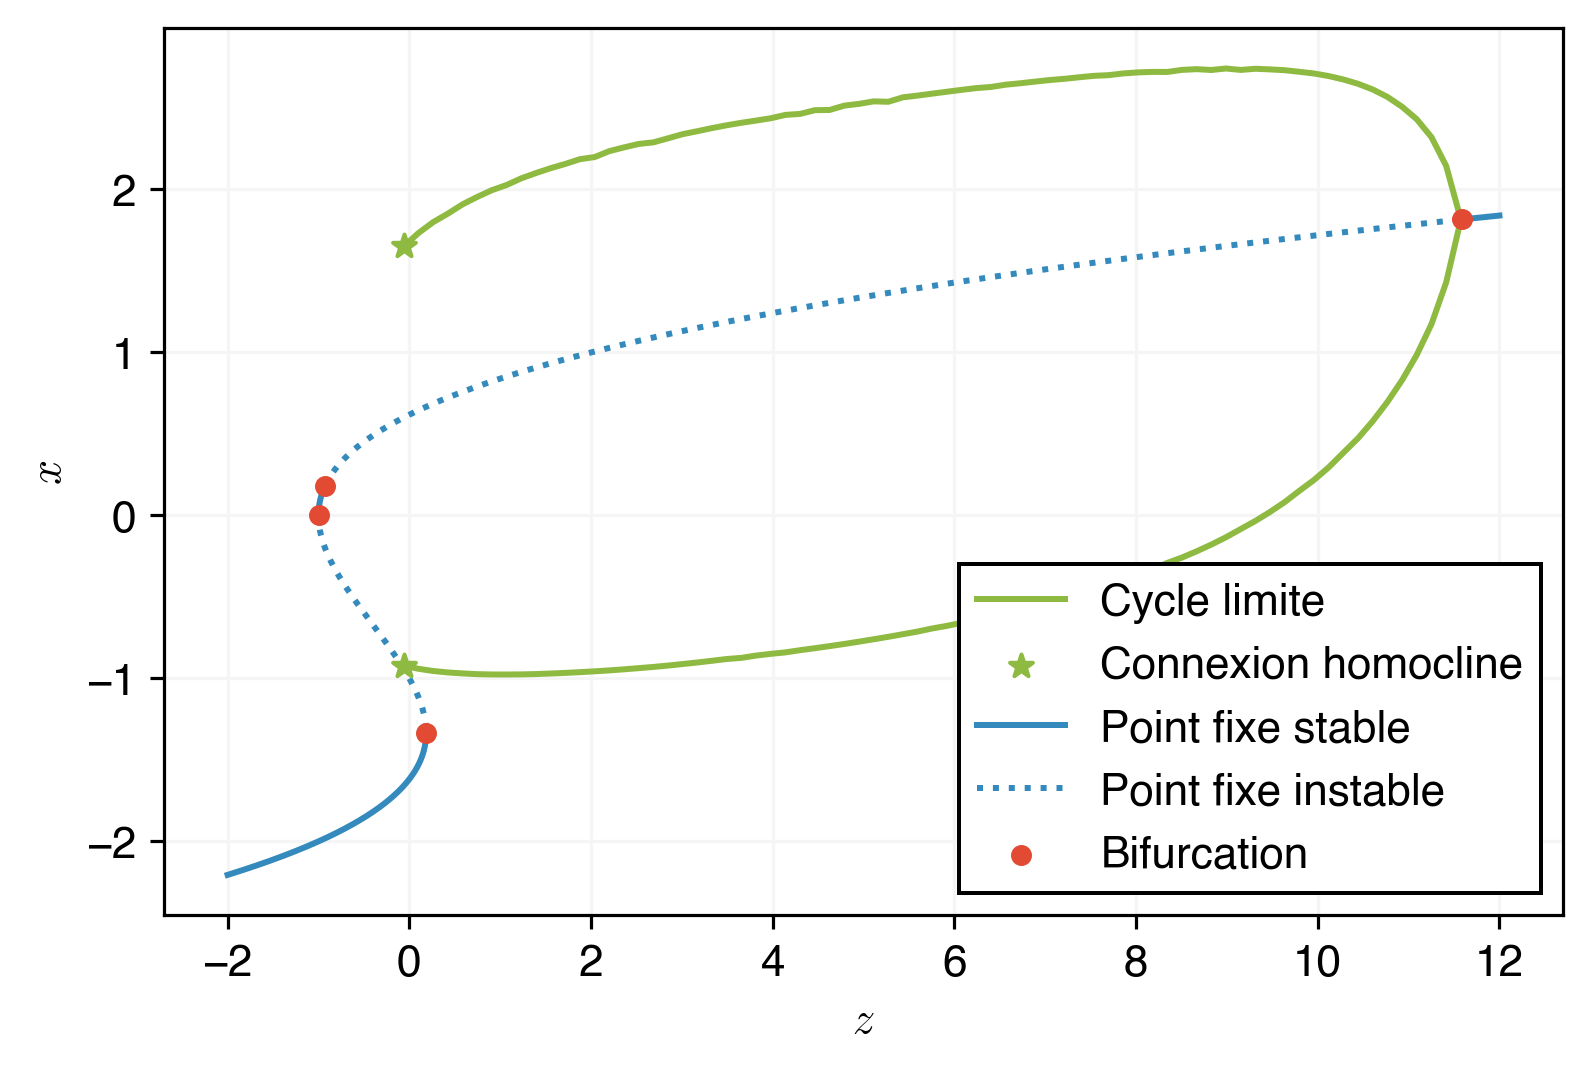

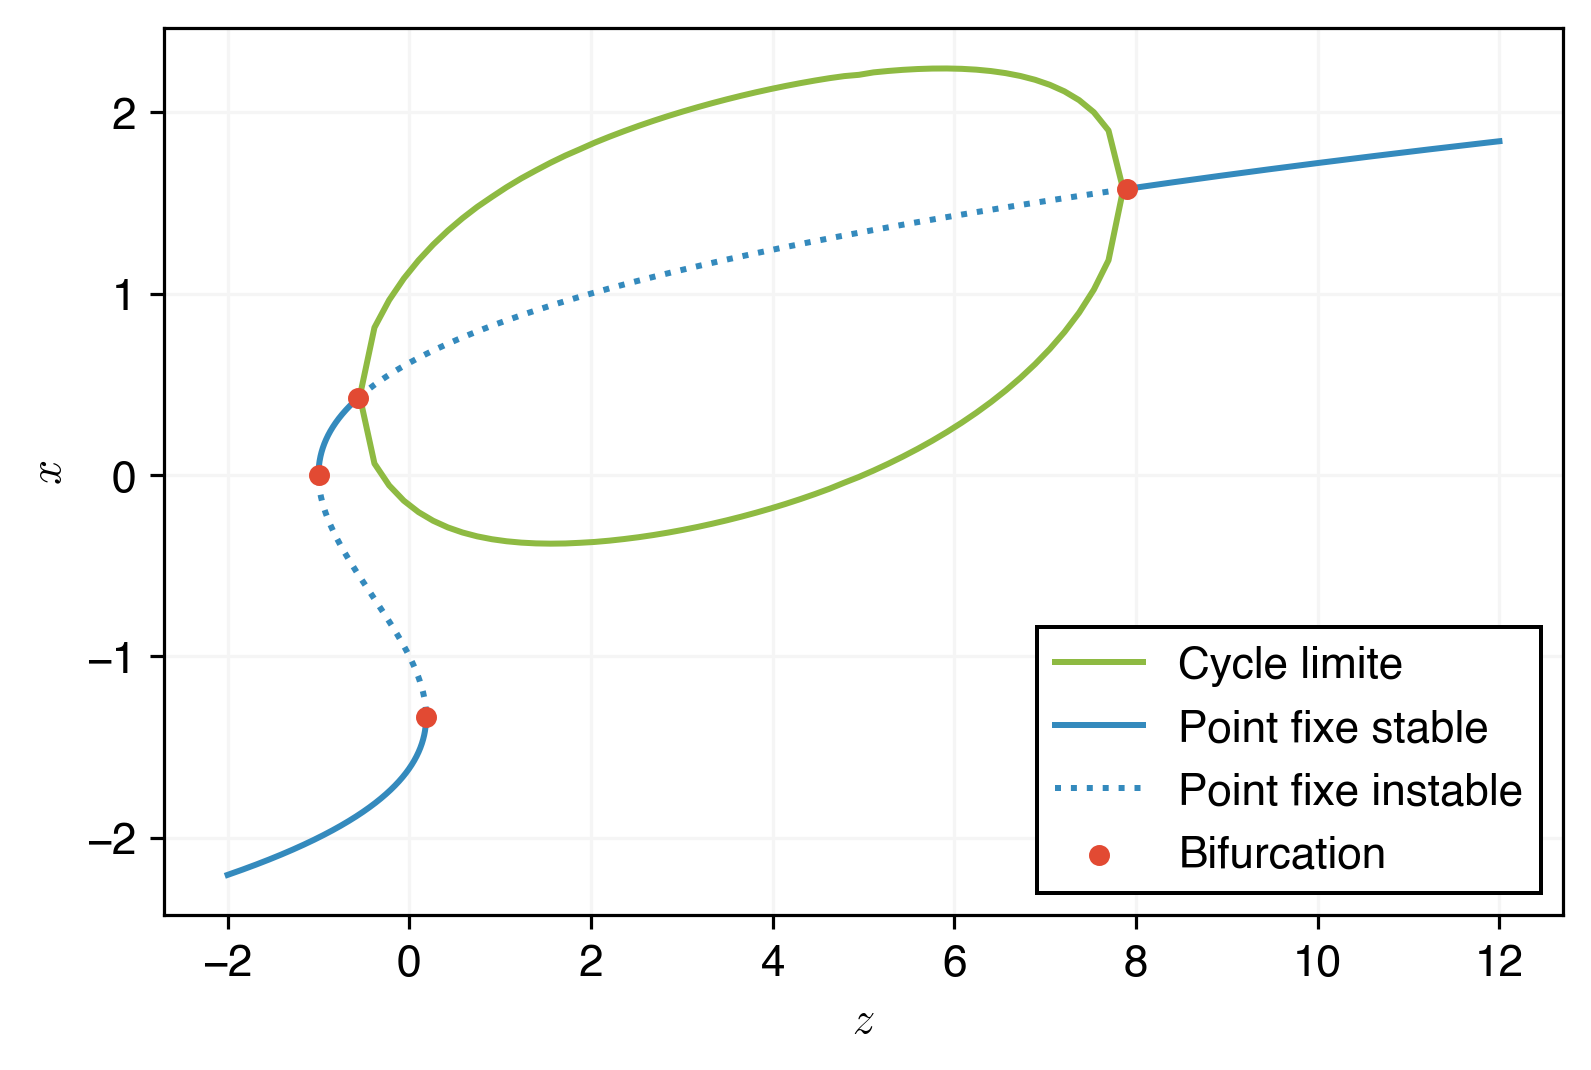

In [8]:
def plot_bifurcation_diagram(model: Model):
  # Calcul des cycles limites
  stat_points = model.get_stat_points(np.linspace(-2, 12, 10000))
  limit_cycle, limit_cycle_sp = get_limit_cycle(model)


  fig, ax = plt.subplots()

  # Affichage de la branche min du cycle limite
  ax.plot(
    limit_cycle_sp[:, 2],
    limit_cycle[:, 0],
    color='C5',
    label='Cycle limite'
  )

  # Affichage de la branche max du cycle limite
  ax.plot(
    limit_cycle_sp[:, 2],
    limit_cycle[:, 1],
    color='C5'
  )

  # Affichage de points pour la connexion homocline
  if model.c == 1:
    ax.scatter([limit_cycle_sp[0, 2]] * 2, limit_cycle[0, :], color='C5', label='Connexion homocline', marker='*', zorder=5)


  # Affichage des points stationnaires
  current_pos = 0

  for index, (stable, count) in enumerate(group(model.is_stable(stat_points))):
    sl = slice(current_pos, current_pos + count)
    current_pos += count

    ax.plot(
      stat_points[sl, 2],
      stat_points[sl, 0],
      color='C0',
      label=(('Point fixe stable' if stable else 'Point fixe instable') if index < 2 else None),
      linestyle=('solid' if stable else 'dotted')
    )

  # Interpolation 1d pour retrouver les valeurs de z correspondant aux bifurcations
  bifurcations_z = interp1d(stat_points[:, 0], stat_points[:, 2])(model.bifurcations_x)

  # Affichage des bifurcations
  ax.scatter(
    bifurcations_z,
    model.bifurcations_x,
    color='C1',
    label='Bifurcation',
    s=18,
    zorder=2
  )

  ax.set_xlabel('$z$')
  ax.set_ylabel('$x$')

  ax.grid()
  ax.legend(loc='lower right')

plot_bifurcation_diagram(model1)
plot_bifurcation_diagram(model2)


## Question 3

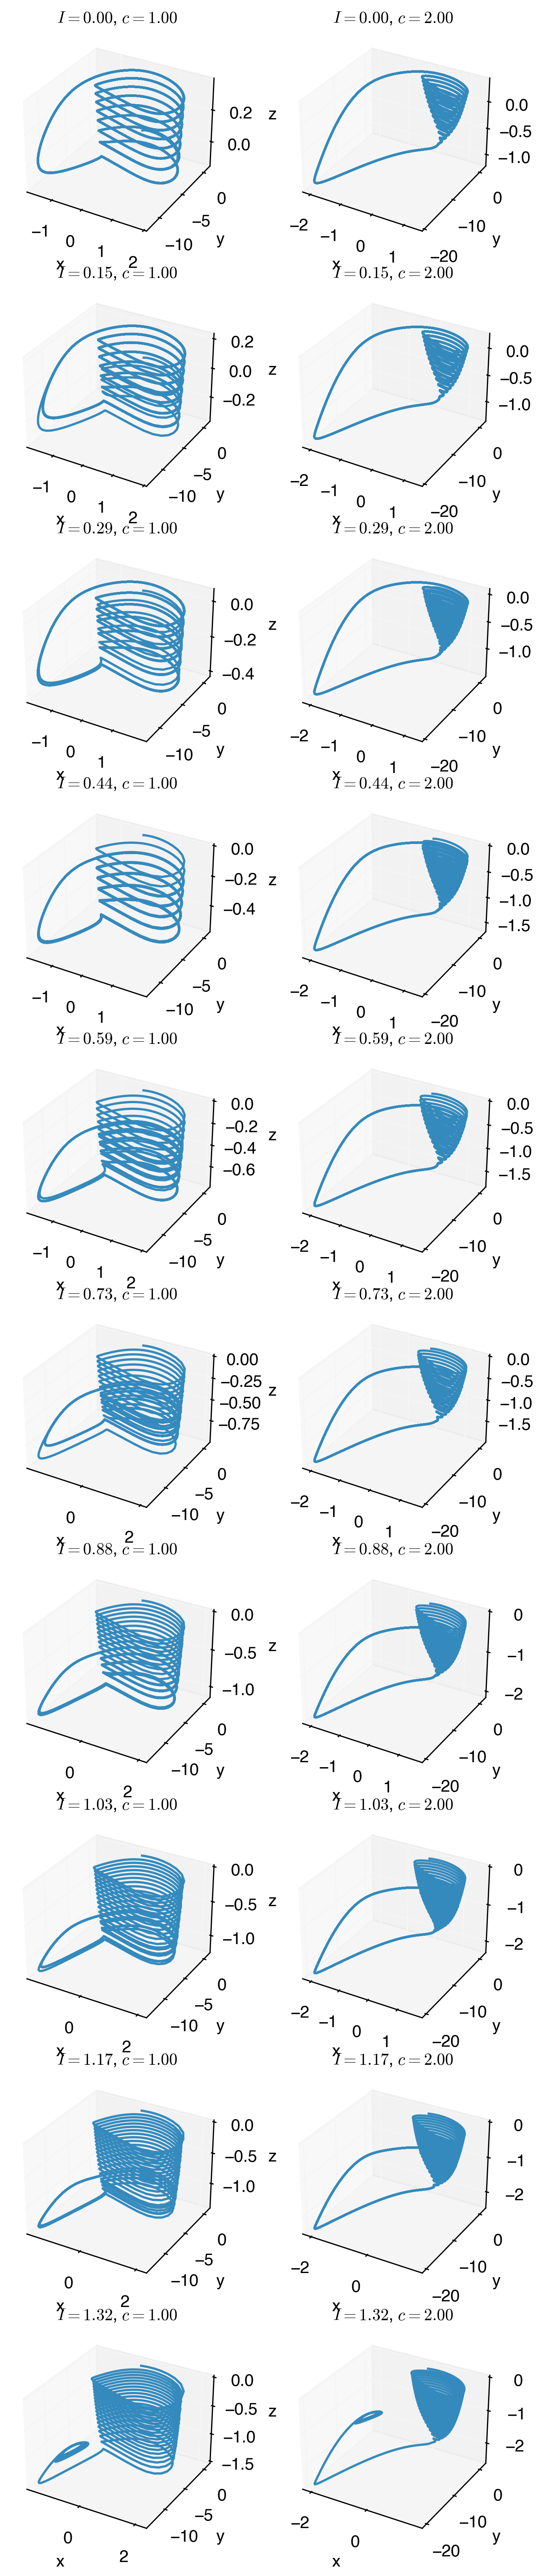

In [9]:
from scipy.integrate import odeint

# Définir les équations différentielles du système 3D
def hindmarsh_rose_3d(state, t, I, c):
    x, y, z = state
    dxdt = (y - x**3 + 3*x**2 + z + I) / c
    dydt = 1 - 5*x**2 - y
    dzdt = 0.01 * (0.3*z - 1 - x)
    return [dxdt, dydt, dzdt]

# Paramètres
I_values = np.linspace(0, 1.32, 10)
t = np.linspace(0, 10000, 100000)
initial_state = [0, 0, 0]

# Liste pour stocker les phases identifiées
phases = []

fig = plt.figure(figsize=(6, 30))

# Simuler le système pour différentes valeurs de I et c
for c_index, c in enumerate([1, 2]):
    for I_index, I in enumerate(I_values):
        state = odeint(hindmarsh_rose_3d, initial_state, t, args=(I, c))
        x, y, z = state[:, 0], state[:, 1], state[:, 2]

        # Tracer les solutions dans l'espace des phases (x, y, z)
        ax = fig.add_subplot(10, 2, c_index + I_index * 2 + 1, projection='3d')
        ax.plot(x, y, z)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title(f'$I={I:.2f}$, $c={c:.2f}$')


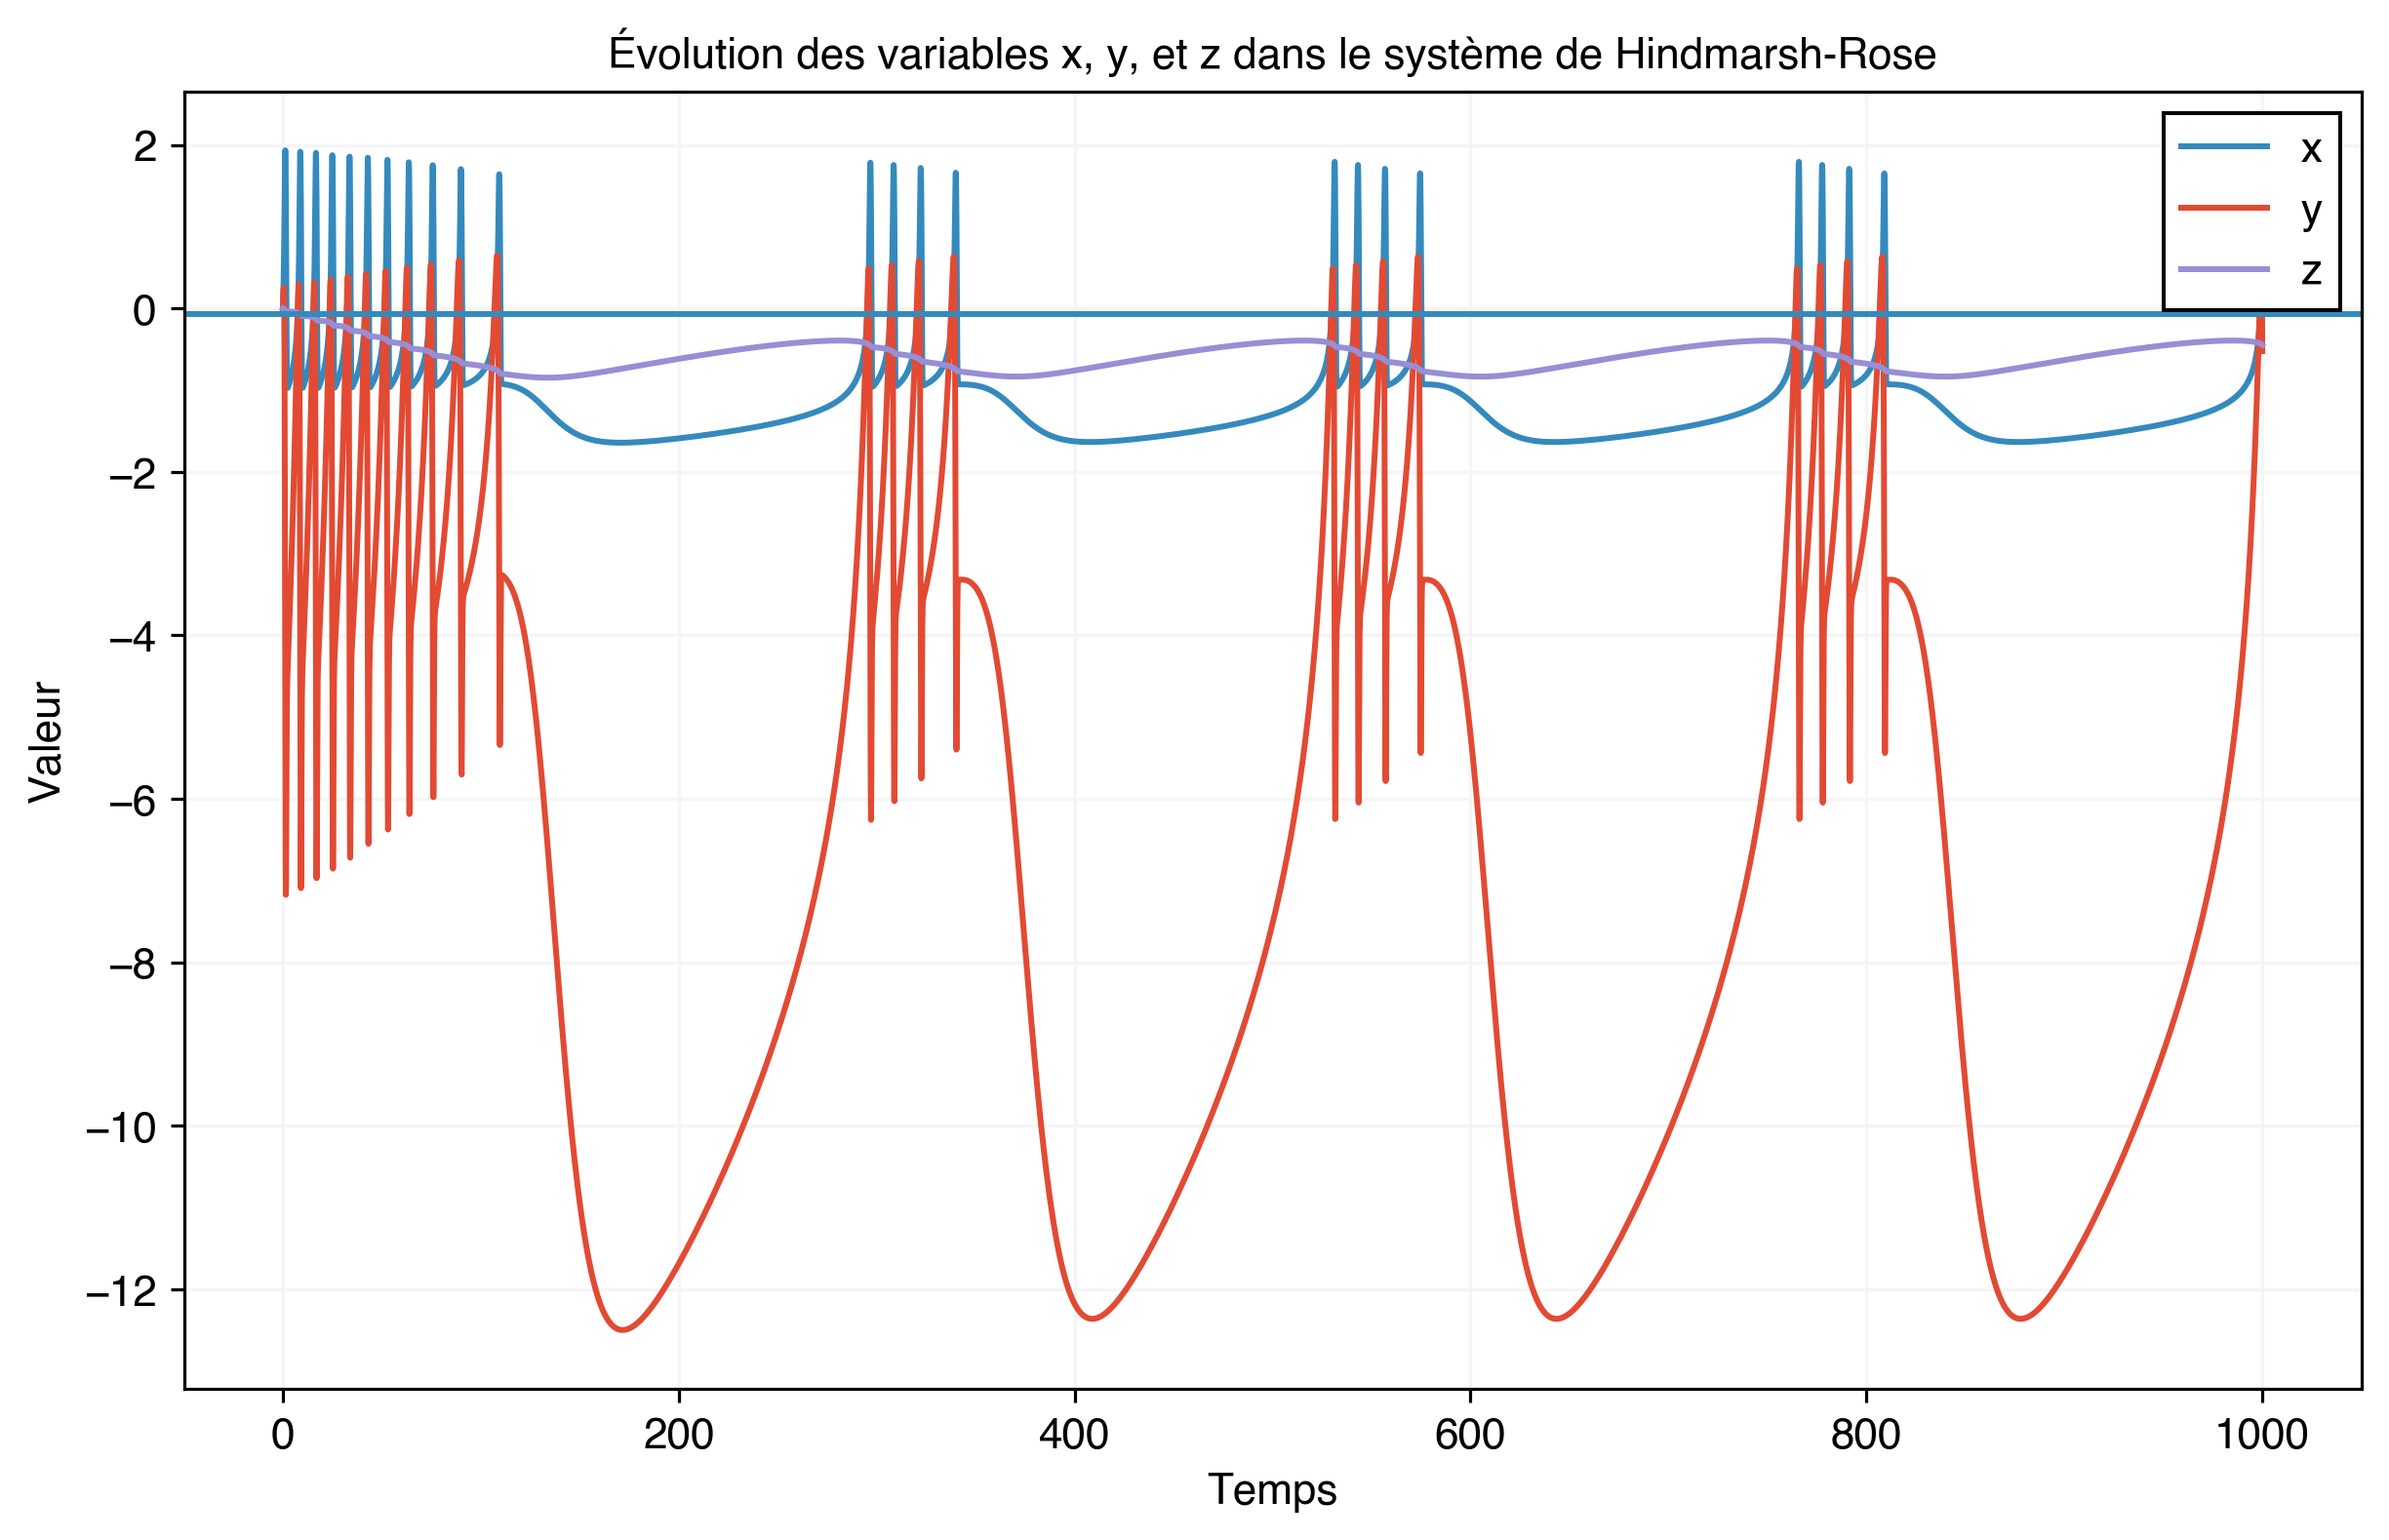

In [10]:
# Paramètres
I = 0.7  # valeur arbitraire pour I
c = 1    # valeur arbitraire pour c
initial_state = [0, 0, 0]  # conditions initiales
t = np.linspace(0, 1000, 10000)  # intervalle de temps pour la simulation

# Simulation du système
state = odeint(hindmarsh_rose_3d, initial_state, t, args=(I, c))
x, y, z = state[:, 0], state[:, 1], state[:, 2]

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.plot(t, z, label='z')
plt.title('Évolution des variables x, y, et z dans le système de Hindmarsh-Rose')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.gca().axhline(-0.07)
plt.show()
